<a href="https://colab.research.google.com/github/cshuler/DL_watershed/blob/master/Scripts/Flow_prediction1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import modules
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import StandardScaler
import keras 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from bisect import bisect_left, bisect_right

# create workspace
if not os.path.exists(os.path.join('.', 'workspace')):
    os.makedirs(os.path.join('.', 'workspace'))
workspace = os.path.join('.', 'workspace')

# set options 
pd.set_option('display.max_rows', 30)  

In [4]:
# Clone DL GitHub repo. 
!git clone -l -s git://github.com/cshuler/DL_watershed cloned-repo
#%cd cloned-repo/Scripts    # get the cwd to be the folder where this script is located to perserve relative paths
# note that repo is cloned. Files saved will save to temprary space if in google colab
#i.e. try not to save any files you 

fatal: destination path 'cloned-repo' already exists and is not an empty directory.


In [16]:
# this is a list of additional functions to load up, as to not clutter the script
%run ../Functions/make_training_dataset
%run ../Functions/find_date_gaps

ERROR:root:File `'../Functions/find_date_gaps.py'` not found.



#### load up data files




In [0]:
# import precip data
preciprawdata = pd.read_csv(os.path.join('Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Precip_mm.csv' ), index_col=0,parse_dates=True)

#import flow data
LBJflowrawdata = pd.read_csv(os.path.join('Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Alex_Q_CFSs.csv'), index_col=0, parse_dates=True)
LBJflowrawdata = LBJflowrawdata.resample('D').mean()     # subsample the 15 min data into daily values

# Create merged precip and flow dataframe indexed by date
mergeddata = pd.merge(preciprawdata, LBJflowrawdata, how='inner', left_index=True, right_index=True) 

# deal with the fact that the beginning and end of the datasets are missing, make them "gaps"
mergeddata['Q_CFS'][0] = mergeddata['Q_CFS'].mean()
mergeddata['Q_CFS'][-1] = mergeddata['Q_CFS'].mean()   # by setting the first and last value to the mean. Super dirty...

unbroken_data = mergeddata.dropna()       # remove any rows where there is no data (a gap)

#### format trainng and validation data

In [12]:
# Note this uses a function from the Functions folder

x_cols = ['Precip_mm']           # define variable used for prediction
y_col  = 'Q_CFS'                    # define which variable to predict

X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler =  make_training_dataset(unbroken_data, x_cols, y_col, TS_value=0.8)

NameError: ignored

In [7]:
# see where there are date gaps using code from Functions folder
where_gaps = find_date_gaps(mergeddata, 'Q_CFS')

gap 0 is 5 days 00:00:00 from 2012-01-02 00:00:00 to 2012-01-07 00:00:00
gap 1 is 6 days 00:00:00 from 2012-04-04 00:00:00 to 2012-04-10 00:00:00
gap 2 is 5 days 00:00:00 from 2012-07-10 00:00:00 to 2012-07-15 00:00:00
gap 3 is 123 days 00:00:00 from 2012-10-11 00:00:00 to 2013-02-11 00:00:00
gap 4 is 137 days 00:00:00 from 2013-09-26 00:00:00 to 2014-02-10 00:00:00
gap 5 is 7 days 00:00:00 from 2014-09-24 00:00:00 to 2014-10-01 00:00:00
gap 6 is 1 days 00:00:00 from 2014-10-09 00:00:00 to 2014-10-10 00:00:00
gap 7 is 230 days 00:00:00 from 2015-06-20 00:00:00 to 2016-02-05 00:00:00
gap 8 is 5 days 00:00:00 from 2016-06-24 00:00:00 to 2016-06-29 00:00:00
gap 9 is 79 days 00:00:00 from 2016-10-13 00:00:00 to 2016-12-31 00:00:00


([Timestamp('2012-01-02 00:00:00'),
  Timestamp('2012-04-04 00:00:00'),
  Timestamp('2012-07-10 00:00:00'),
  Timestamp('2012-10-11 00:00:00'),
  Timestamp('2013-09-26 00:00:00'),
  Timestamp('2014-09-24 00:00:00'),
  Timestamp('2014-10-09 00:00:00'),
  Timestamp('2015-06-20 00:00:00'),
  Timestamp('2016-06-24 00:00:00'),
  Timestamp('2016-10-13 00:00:00')],
 [Timestamp('2012-01-07 00:00:00'),
  Timestamp('2012-04-10 00:00:00'),
  Timestamp('2012-07-15 00:00:00'),
  Timestamp('2013-02-11 00:00:00'),
  Timestamp('2014-02-10 00:00:00'),
  Timestamp('2014-10-01 00:00:00'),
  Timestamp('2014-10-10 00:00:00'),
  Timestamp('2016-02-05 00:00:00'),
  Timestamp('2016-06-29 00:00:00'),
  Timestamp('2016-12-31 00:00:00')])

In [125]:
# this is the creation of the DLNN model as a function
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    return model


# Define the model: 

# DL hyperparameters
hidden_layer_sizes =  [2, 4, 8, 4]
activation     = 'relu'
optimizer      = 'sgd'
input_shape    = 1           # this is the number of different variables used for training datasets

model = "reset"; del model                                                           # redefine, then delete model to make sure previous model weights are DESTROIED!
model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [126]:
# run the model

# Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=300, mode='min', min_delta=0.001),
                      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

## load the best saved model based on validation loss
model = load_model(checkpoint_path)
scores = model.evaluate(X_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

983/983 [==============================] - 0s 141us/step
Score: loss of 0.37372303833675286; mean_squared_error of 37.37230383367528%


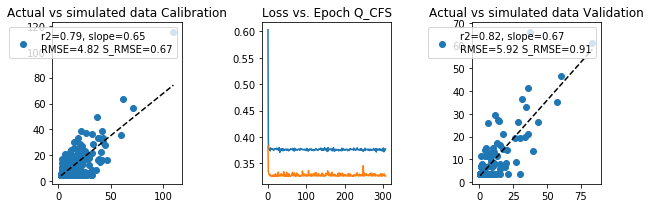

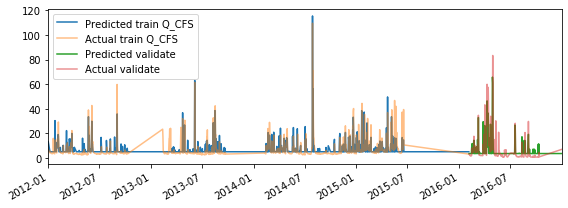

In [127]:
#### Plot results
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
####################################################     DELETE   fig.suptitle('Validation test plots', fontsize=16)

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()
plt.tight_layout()

###### Plot losses
ax[1].set_title('Loss vs. Epoch {}'.format(y_col))
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
plt.tight_layout()

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee
plt.tight_layout()

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()
plt.tight_layout() 

##### time series plot
plt.figure(figsize=(8, 3))
plt.plot(train_data.index, ycal, label='Predicted train {}'.format(y_col))
train_data[y_col].plot(label='Actual train {}'.format(y_col) , alpha = .5)
plt.plot(val_data.index, yval, label='Predicted validate')
val_data[y_col].plot(label='Actual validate', alpha = .5)
plt.legend(loc='best')
plt.tight_layout()

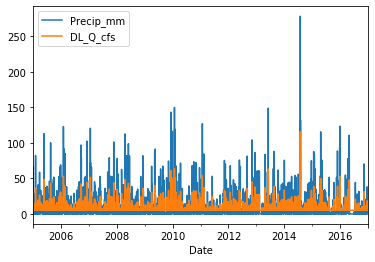

In [128]:
X_fill = preciprawdata['Precip_mm'].to_numpy()
X_fill =  X_train_scaler.transform([X_fill])                           # scale existing data in other columns 

# now model streamflow for the whole period where we have precip data
y_pred_fill = model.predict(np.squeeze(X_fill))
y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above 

Magicdata = preciprawdata.copy()
Magicdata['DL_Q_cfs'] = y_pred_fill

Magicdata.plot()

del Magicdata.index.name   # baseflow separator wont work without this

In [130]:
# calculate streamflow stats on each tineseries

MF_mean = Magicdata['DL_Q_cfs'].mean()
print("actual flow mean is {}, magic flow mean is {} CFS".format(LBJflowrawdata.mean().values, MF_mean))

MF_med = Magicdata['DL_Q_cfs'].median()
print("actual flow median is {}, magic flow median is {} CFS".format(LBJflowrawdata.median().values, MF_med))

All_flows_real, RO_mean_real, BF_mean_real, TF_mean_real = baseflow_separator(LBJflowrawdata.index, LBJflowrawdata['Q_CFS'])
All_flows_magic, RO_mean_magic, BF_mean_magic, TF_mean_magic = baseflow_separator(Magicdata.index, Magicdata['DL_Q_cfs'])

print("actual flow BF is {}, magic flow BF is {} CFS".format(BF_mean_real, BF_mean_magic))
print("actual flow RO is {}, magic flow RO is {} CFS".format(RO_mean_real, RO_mean_magic))

# Calculate exceedednce values
Desired_Q_exceed_value = .90

data = Magicdata['DL_Q_cfs'].to_numpy()
sort = np.sort(data)[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)
excedenceframe = pd.DataFrame(data=sort, index=exceedence, columns=['flow'])
idx = bisect_left(excedenceframe.index, Desired_Q_exceed_value)
Magic_sceed_flow = excedenceframe["flow"].iloc[idx]

LBJflowrawdata = LBJflowrawdata.dropna() # need to drop nan rows first
data = LBJflowrawdata['Q_CFS'].to_numpy()
sort = np.sort(data)[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)
excedenceframe = pd.DataFrame(data=sort, index=exceedence, columns=['flow'])
idx = bisect_left(excedenceframe.index, Desired_Q_exceed_value)
real_sceed_flow = excedenceframe["flow"].iloc[idx]

print('The Q_{} value is {} for real data and {} for magic data'.format(Desired_Q_exceed_value, real_sceed_flow, Magic_sceed_flow))


actual flow mean is [7.0178287], magic flow mean is 7.333120822906494 CFS
actual flow median is [4.25615707], magic flow median is 5.116145610809326 CFS
actual flow BF is 3.3047185914476676, magic flow BF is 5.117574851262515 CFS
actual flow RO is 3.738101516345077, magic flow RO is 2.210914019101287 CFS
The Q_0.9 value is 2.515436652083331 for real data and 5.116145610809326 for magic data
